#	Обучить модель на данных о числе новых выявленных случаев заболевания covid-19 в период с 01.01.2020 по 01.01.2021 в странах: Россия, Италия, Германия и Франция

In [20]:
import pandas as pd
import warnings

warnings.simplefilter(action="ignore", category=FutureWarning)

import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import numpy as np
import os
import arviz as az
import numpy as np
import pandas as pd
from scipy import stats as sps
import pytensor.tensor as pt
import pytensor
import pymc as pm

In [2]:
data = pd.read_csv('owid-covid-data.csv')

In [7]:
data.total_tests.isna().sum()

121633

In [3]:
data

iso_code continent     location        date  total_cases  new_cases  \
0           AFG      Asia  Afghanistan  2020-02-24          5.0        5.0   
1           AFG      Asia  Afghanistan  2020-02-25          5.0        0.0   
2           AFG      Asia  Afghanistan  2020-02-26          5.0        0.0   
3           AFG      Asia  Afghanistan  2020-02-27          5.0        0.0   
4           AFG      Asia  Afghanistan  2020-02-28          5.0        0.0   
...         ...       ...          ...         ...          ...        ...   
201013      ZWE    Africa     Zimbabwe  2022-07-09     255924.0       33.0   
201014      ZWE    Africa     Zimbabwe  2022-07-10     255939.0       15.0   
201015      ZWE    Africa     Zimbabwe  2022-07-11     255953.0       14.0   
201016      ZWE    Africa     Zimbabwe  2022-07-12     255981.0       28.0   
201017      ZWE    Africa     Zimbabwe  2022-07-13     255981.0        0.0   

        new_cases_smoothed  total_deaths  new_deaths  new_deaths_smoothed  \
0                      NaN           NaN         NaN                  NaN   
1                      NaN           NaN         NaN                  NaN   
2                      NaN           NaN         NaN                  NaN   
3                      NaN           NaN         NaN                  NaN   
4                      NaN           NaN         NaN                  NaN   
...                    ...           ...         ...                  ...   
201013              48.286        5563.0         1.0                1.143   
201014              50.429        5564.0         1.0                1.286   
201015              32.429        5565.0         1.0                1.000   
201016              32.286        5565.0         0.0                1.000   
201017              25.143        5565.0         0.0                0.714   

        ...  female_smokers  male_smokers  handwashing_facilities  \
0       ...             NaN           NaN                  37.746   
1       ...             NaN           NaN                  37.746   
2       ...             NaN           NaN                  37.746   
3       ...             NaN           NaN                  37.746   
4       ...             NaN           NaN                  37.746   
...     ...             ...           ...                     ...   
201013  ...             1.6          30.7                  36.791   
201014  ...             1.6          30.7                  36.791   
201015  ...             1.6          30.7                  36.791   
201016  ...             1.6          30.7                  36.791   
201017  ...             1.6          30.7                  36.791   

        hospital_beds_per_thousand  life_expectancy  human_development_index  \
0                              0.5            64.83                    0.511   
1                              0.5            64.83                    0.511   
2                              0.5            64.83                    0.511   
3                              0.5            64.83                    0.511   
4                              0.5            64.83                    0.511   
...                            ...              ...                      ...   
201013                         1.7            61.49                    0.571   
201014                         1.7            61.49                    0.571   
201015                         1.7            61.49                    0.571   
201016                         1.7            61.49                    0.571   
201017                         1.7            61.49                    0.571   

        excess_mortality_cumulative_absolute  excess_mortality_cumulative  \
0                                        NaN                          NaN   
1                                        NaN                          NaN   
2                                        NaN                          NaN   
3                                        NaN   

In [21]:
def prepare_data_country(data, country, 
                        window_size=7,
                        start_date='2020-01-01',
                        end_date='2021-01-01',
                        std_threshold=3,
                        nan_threshold=0.5):  # если более 50% NaN, используем прокси

    df_country = data.loc[lambda x: (x.location == country)].copy()
    df_country = df_country.set_index('date')
    
    # Выбираем временной период
    df_country = df_country.loc[start_date:end_date]
    
    # Обработка новых случаев
    new_cases = df_country['new_cases'].clip(lower=0)
    new_cases = new_cases.fillna(method='ffill')
    new_cases = new_cases.fillna(method='bfill')
    new_cases = new_cases.fillna(0)
    
    # Скользящие статистики для случаев
    rolling_mean = new_cases.rolling(
        window=window_size, 
        center=True, 
        min_periods=1
    ).mean()
    
    rolling_median = new_cases.rolling(
        window=window_size, 
        center=True, 
        min_periods=1
    ).median()
    
    rolling_std = new_cases.rolling(
        window=window_size, 
        center=True, 
        min_periods=1
    ).std()
    
    # Заполнение пропусков и обработка выбросов для случаев
    new_cases = new_cases.fillna(rolling_mean)
    is_outlier = np.abs(new_cases - rolling_median) > std_threshold * rolling_std
    new_cases[is_outlier] = rolling_median[is_outlier]
    new_cases = new_cases.clip(lower=1)
    
    # Обработка тестов
    use_proxy = True  # по умолчанию используем прокси
    
    if 'new_tests' in df_country.columns:
        total_tests = df_country['new_tests']
        nan_ratio = total_tests.isna().mean()
        
        if nan_ratio <= nan_threshold:  # если NaN меньше порога
            use_proxy = False
            total_tests = total_tests.fillna(0).clip(lower=0)
            
            # Скользящие статистики для тестов
            tests_rolling_mean = total_tests.rolling(
                window=window_size, 
                center=True, 
                min_periods=1
            ).mean()
            
            tests_rolling_median = total_tests.rolling(
                window=window_size, 
                center=True, 
                min_periods=1
            ).median()
            
            tests_rolling_std = total_tests.rolling(
                window=window_size, 
                center=True, 
                min_periods=1
            ).std()
            
            # Обработка выбросов
            is_test_outlier = np.abs(total_tests - tests_rolling_median) > std_threshold * tests_rolling_std
            total_tests[is_test_outlier] = tests_rolling_median[is_test_outlier]
    
    if use_proxy:
        print(f"Using proxy for tests in {country} (NaN ratio: {nan_ratio:.2%})")
        # Создаем прокси на основе случаев
        total_tests = pd.Series(1, index=new_cases.index)  # заполняем нулями
    
    # Финальная проверка
    total_tests = total_tests.fillna(0)  # на всякий случай
    
    assert not np.isnan(total_tests).any(), "Still have NaN in total_tests"
    assert not np.isnan(new_cases).any(), "Still have NaN in new_cases"
    
    return new_cases, total_tests

Using proxy for tests in Germany (NaN ratio: 100.00%)


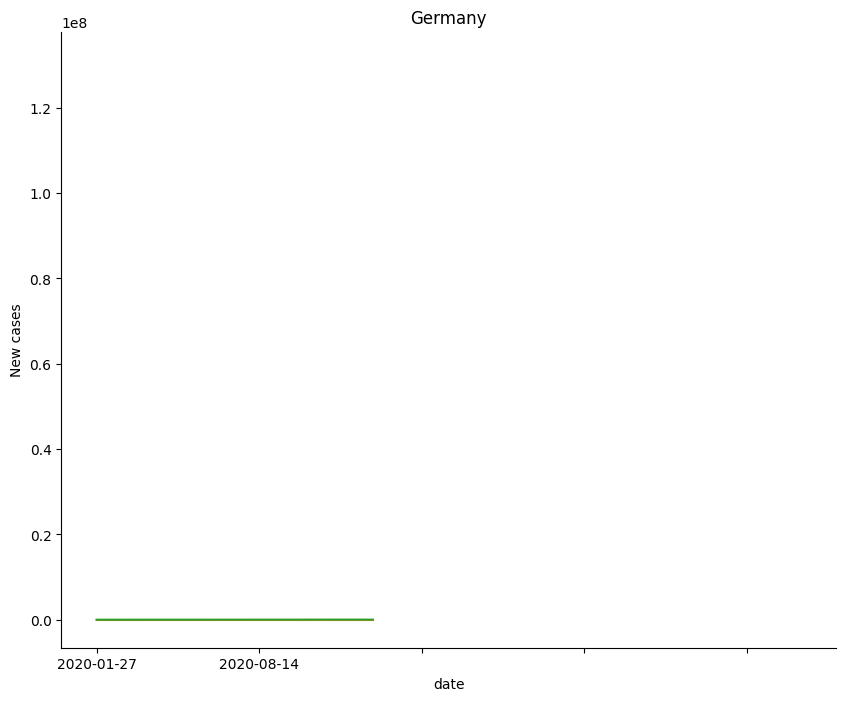

In [22]:
country = "Germany"
df_country = data.loc[lambda x: (x.location == country)].set_index('date').total_tests

fig, ax = plt.subplots(figsize=(10, 8))
new_cases,total_tests = prepare_data_country(data, country)
df_country.plot(ax=ax)
total_tests.plot(ax=ax)
new_cases.plot(ax=ax)
ax.set(ylabel="New cases", title=country)
sns.despine()

In [111]:
new_cases.isna().sum()

0

In [58]:
data.columns

Index(['iso_code', 'continent', 'location', 'date', 'total_cases', 'new_cases',
       'new_cases_smoothed', 'total_deaths', 'new_deaths',
       'new_deaths_smoothed', 'total_cases_per_million',
       'new_cases_per_million', 'new_cases_smoothed_per_million',
       'total_deaths_per_million', 'new_deaths_per_million',
       'new_deaths_smoothed_per_million', 'reproduction_rate', 'icu_patients',
       'icu_patients_per_million', 'hosp_patients',
       'hosp_patients_per_million', 'weekly_icu_admissions',
       'weekly_icu_admissions_per_million', 'weekly_hosp_admissions',
       'weekly_hosp_admissions_per_million', 'total_tests', 'new_tests',
       'total_tests_per_thousand', 'new_tests_per_thousand',
       'new_tests_smoothed', 'new_tests_smoothed_per_thousand',
       'positive_rate', 'tests_per_case', 'tests_units', 'total_vaccinations',
       'people_vaccinated', 'people_fully_vaccinated', 'total_boosters',
       'new_vaccinations', 'new_vaccinations_smoothed',
       't

In [23]:
def _get_generation_time_interval():
    """ Create a discrete P(Generation Interval)
        Source: https://www.ijidonline.com/article/S1201-9712(20)30119-3/pdf """
    mean_si = 4.7
    std_si = 2.9
    mu_si = np.log(mean_si ** 2 / np.sqrt(std_si ** 2 + mean_si ** 2))
    sigma_si = np.sqrt(np.log(std_si ** 2 / mean_si ** 2 + 1))
    dist = sps.lognorm(scale=np.exp(mu_si), s=sigma_si)

    # Discretize the Generation Interval up to 20 days max
    g_range = np.arange(0, 20)
    gt = pd.Series(dist.cdf(g_range), index=g_range)
    gt = gt.diff().fillna(0)
    gt /= gt.sum()
    gt = gt.values
    return gt

def _get_convolution_ready_gt(len_observed):
    """ Speeds up theano.scan by pre-computing the generation time interval
        vector. Thank you to Junpeng Lao for this optimization.
        Please see the outbreak simulation math here:
        https://staff.math.su.se/hoehle/blog/2020/04/15/effectiveR0.html """
    gt = _get_generation_time_interval()
    convolution_ready_gt = np.zeros((len_observed - 1, len_observed))
    for t in range(1, len_observed):
        begin = np.maximum(0, t - len(gt) + 1)
        slice_update = gt[1 : t - begin + 1][::-1]
        convolution_ready_gt[
            t - 1, begin : begin + len(slice_update)
        ] = slice_update
    convolution_ready_gt = pytensor.shared(convolution_ready_gt)
    return convolution_ready_gt


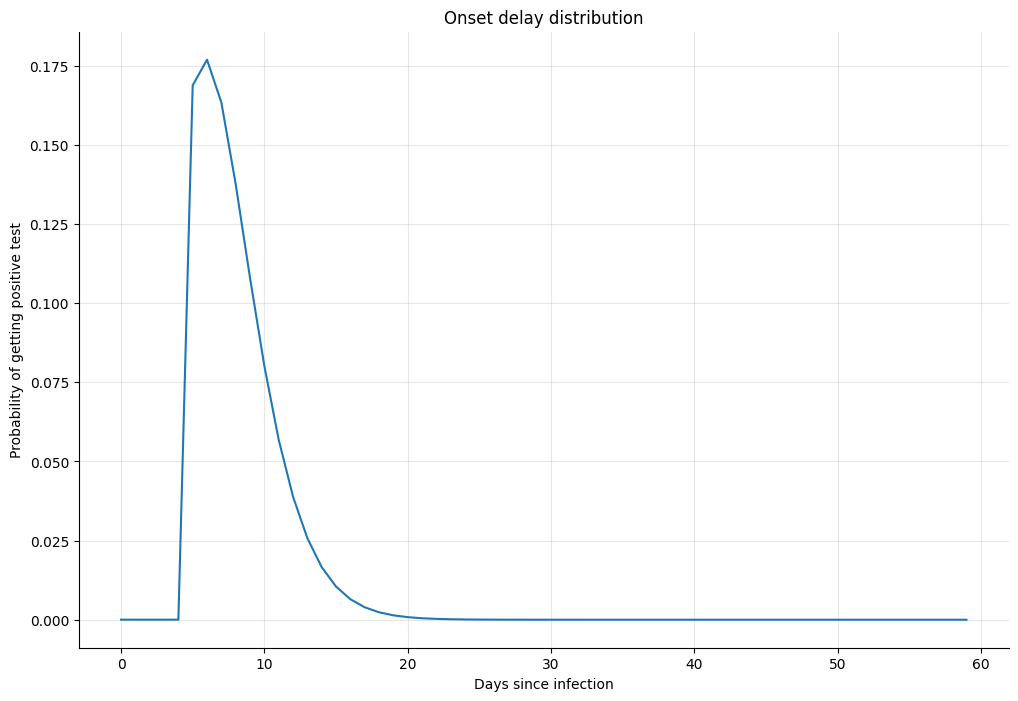

In [24]:
max_delay = 60
delay_days = np.arange(max_delay)

# Создаем гамма-распределение
p_delay = pd.Series(
    sps.gamma.pdf(delay_days, a=5.48, scale=1/0.77),  # shape=5.48, rate=0.77
    index=delay_days
)

# Нормализуем распределение
p_delay = p_delay / p_delay.sum()

# Устанавливаем малые значения для первых 5 дней
p_delay.iloc[:5] = 1e-5

# Повторная нормализация после модификации
p_delay = p_delay / p_delay.sum()

# Визуализация
plt.figure(figsize=(12, 8))
ax = p_delay.plot()
ax.set(
    title="Onset delay distribution",
    ylabel="Probability of getting positive test",
    xlabel="Days since infection"
)
sns.despine()
plt.grid(True, alpha=0.3)


In [14]:
new_cases,total_tests = prepare_data_country(data,  'Germany')
total_tests.isna().sum()

Using proxy for tests in Germany (NaN ratio: 100.00%)


0

In [64]:
new_cases

date
2020-01-27        1.0
2020-01-28        3.0
2020-01-29        1.0
2020-01-30        1.0
2020-01-31        1.0
               ...   
2020-12-28    10976.0
2020-12-29    12892.0
2020-12-30    22459.0
2020-12-31    32552.0
2021-01-01    22924.0
Name: new_cases, Length: 341, dtype: float64

In [101]:

def summarize_inference_data(inference_data: az.InferenceData, new_cases):
    """ Summarizes an inference_data object into the form that we publish on rt.live """
    posterior = inference_data.posterior
    hdi_mass = 80
    hpdi = az.hdi(posterior.r_t, hdi_prob=hdi_mass / 100).r_t

    observed_positive = new_cases.values
    scale_to_positives = lambda data: observed_positive.mean() / np.mean(data) * data
    tests = inference_data.constant_data.tests.to_series()
    normalized_positive = observed_positive/tests.clip(0.1 * tests.max())

    summary = pd.DataFrame(
        data={
            "mean": posterior.r_t.mean(["draw", "chain"]),
            "median": posterior.r_t.median(["chain", "draw"]),
            f"lower_{hdi_mass}": hpdi[:, 0],
            f"upper_{hdi_mass}": hpdi[:, 1],
            "infections": scale_to_positives(
                posterior.infections.mean(["draw", "chain"])
            ),
            "test_adjusted_positive": scale_to_positives(
                posterior.test_adjusted_positive.mean(["draw", "chain"])
            ),
            "test_adjusted_positive_raw": scale_to_positives(normalized_positive),
            "positive": observed_positive,
            "tests": tests,
        },
        index=pd.Index(posterior.log_r_t_dim_0.values, name="date"),
    )
    return summary

def conv_r(a, b, len_observed):
    """Perform a 1D convolution of a and b"""
    from pytensor.tensor.conv import conv2d

    a_4d = pt.reshape(a, (1, 1, 1, len_observed))
    b_4d = pt.reshape(b, (1, 1, 1, len(b)))
    
    # Выполняем свертку
    result = conv2d(
        input=a_4d,
        filters=b_4d,
        input_shape=(1, 1, 1, len_observed),
        filter_shape=(1, 1, 1, len(b)),
        border_mode="full"
    )
    
    # Извлекаем нужную часть результата
    return result[0, 0, 0, :len_observed]

In [102]:
new_cases,total_tests = prepare_data_country(data, 'Russia')
result = summarize_inference_data(results_my_2['Russia']['trace'],new_cases)


In [96]:
result

mean    median  lower_80  upper_80    infections  \
date                                                         
0     1.229379  1.217174  1.028018  1.426949     11.747120   
1     1.234080  1.224790  1.033948  1.422575      0.102402   
2     1.238305  1.228125  1.042175  1.416215      1.451684   
3     1.243407  1.234442  1.055716  1.421454      2.751549   
4     1.249883  1.241867  1.066298  1.418234      2.939099   
...        ...       ...       ...       ...           ...   
332   0.846724  0.839977  0.690686  0.981955  15447.929157   
333   0.846773  0.838029  0.671459  0.974001  15015.316282   
334   0.847261  0.839369  0.669485  0.979132  14604.382069   
335   0.847405  0.839005  0.666770  0.984254  14213.327093   
336   0.847922  0.837874  0.668258  0.995021  13841.787617   

      test_adjusted_positive  test_adjusted_positive_raw  positive     tests  
date                                                                          
0                   0.000152                    8.752735       2.0       0.0  
1                   0.000154                    4.376368       1.0       0.0  
2                   0.000172                    4.376368       1.0       0.0  
3                   0.000208                    4.376368       1.0       0.0  
4                   0.000246                    4.376368       1.0       0.0  
...                      ...                         ...       ...       ...  
332             20704.523505                26527.268520   27363.0  292690.0  
333             20048.634806                19099.257608   26588.0  395008.0  
334             19419.176935                16638.698761   26095.0  445015.0  
335             18816.004897                16351.572305   27329.0  474243.0  
336             18238.827510                19563.299869   26613.0  386001.0  

[337 rows x 9 columns]

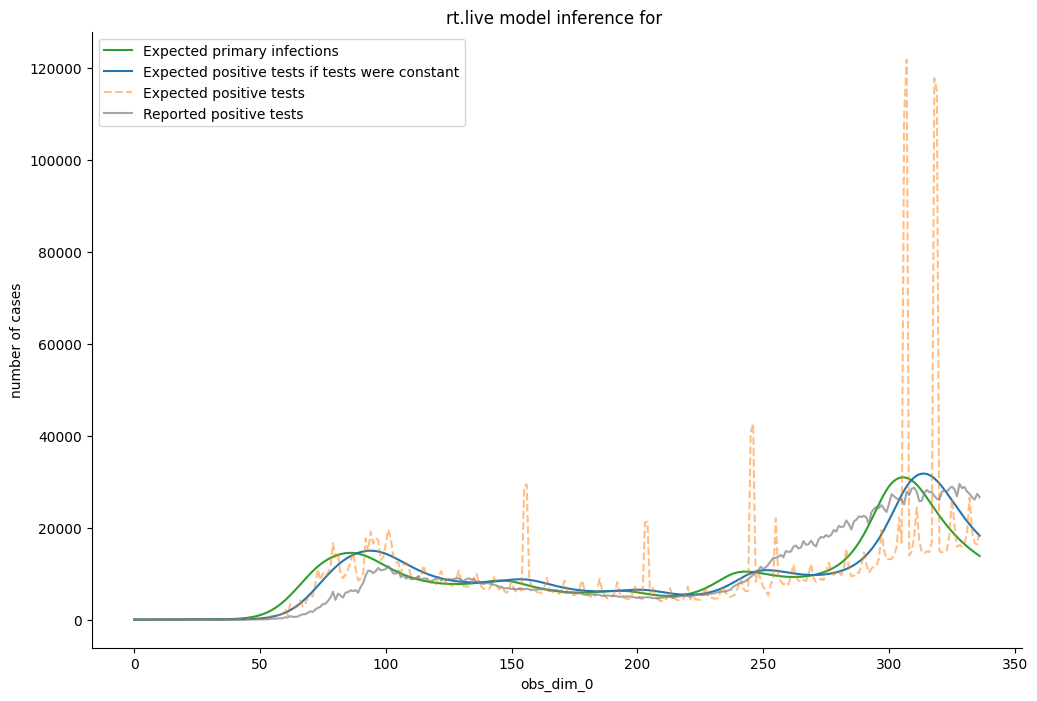

In [103]:
fig, ax = plt.subplots(figsize=(12, 8))
result.infections.plot(c="C2", label="Expected primary infections")
result.test_adjusted_positive.plot(
    c="C0", label="Expected positive tests if tests were constant"
)
# results_my_2['Russia']['trace'].test_adjusted_positive
result.test_adjusted_positive_raw.plot(
    c="C1", alpha=0.5, label="Expected positive tests", style="--"
)
if region != 'Germany':
    results_my_2['Russia']['trace'].observed_data.obs.plot(c="C7", alpha=0.7, label="Reported positive tests")
fig.set_facecolor("w")
ax.legend()
ax.set(title=f"rt.live model inference for ", ylabel="number of cases")
sns.despine();



Processing France...
Sampling prior predictive...
Running main sampling...


c:\Users\User\anaconda3\envs\MRI_NiR\Lib\site-packages\pymc\distributions\timeseries.py:297: UserWarning: Initial distribution not specified, defaulting to `Normal.dist(0, 100)`.You can specify an init_dist manually to suppress this warning.
  warnings.warn(
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (3 chains in 3 jobs)
NUTS: [log_r_t, seed, omega, alpha]


Output()

Sampling 3 chains for 700 tune and 1_500 draw iterations (2_100 + 4_500 draws total) took 2019 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnostics
c:\Users\User\anaconda3\envs\MRI_NiR\Lib\site-packages\arviz\stats\density_utils.py:488: UserWarning: Your data appears to have a single value or no finite values
  warnings.warn("Your data appears to have a single value or no finite values")
c:\Users\User\anaconda3\envs\MRI_NiR\Lib\site-packages\arviz\stats\density_utils.py:488: UserWarning: Your data appears to have a single value or no finite values
  warnings.warn("Your data appears to have a single value or no finite values")
Sampling: [obs]


Output()

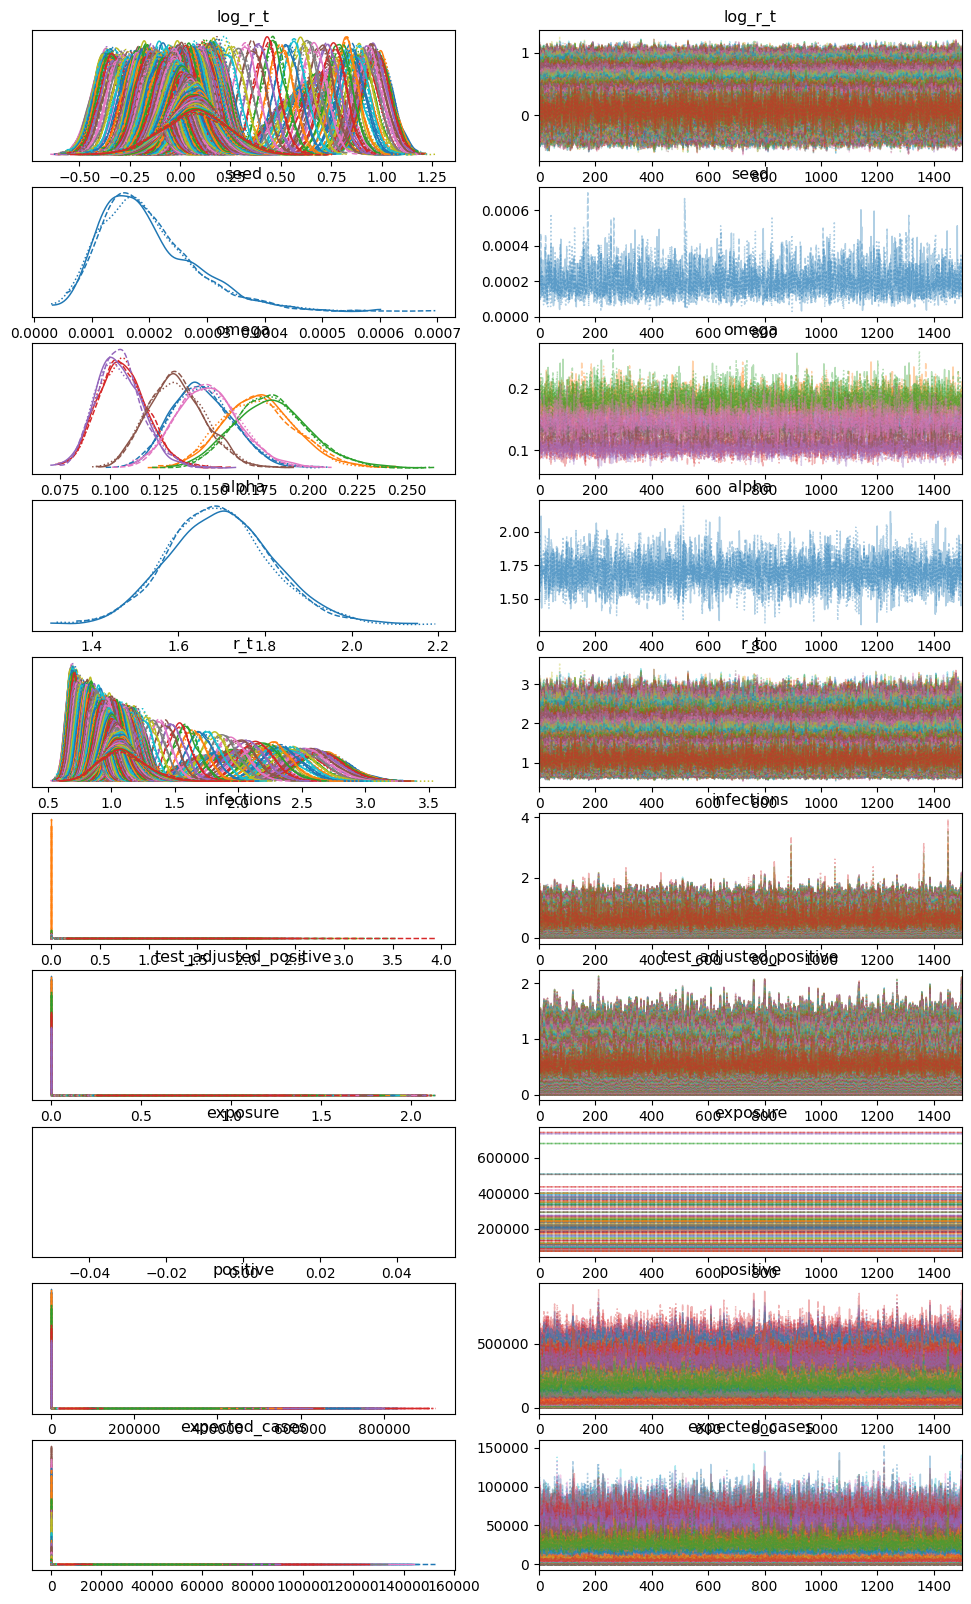

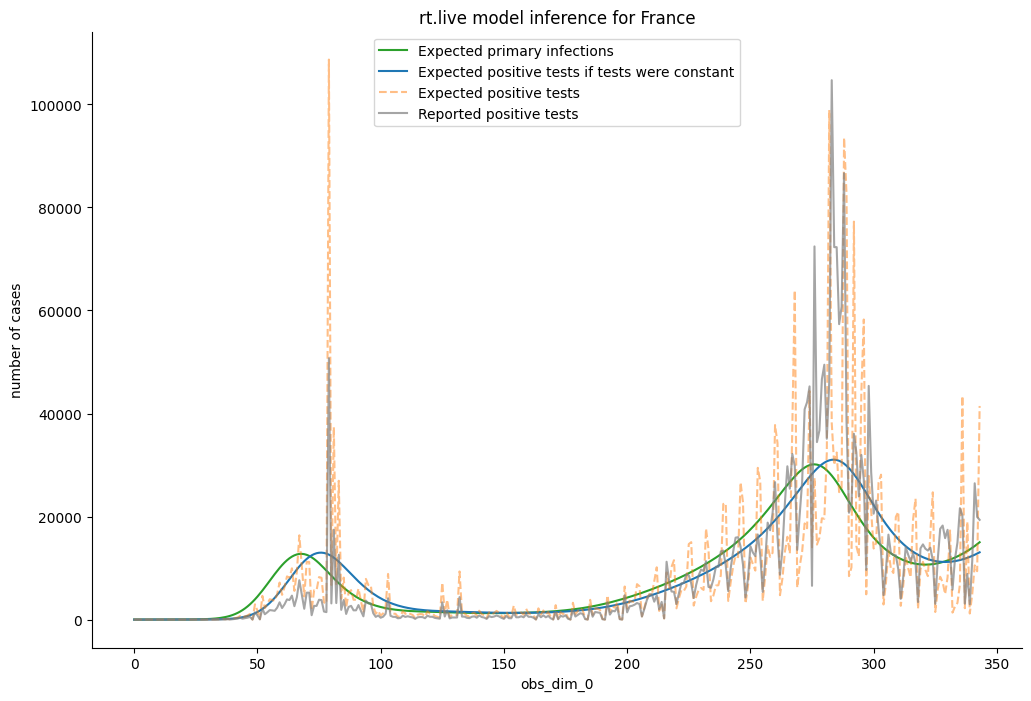

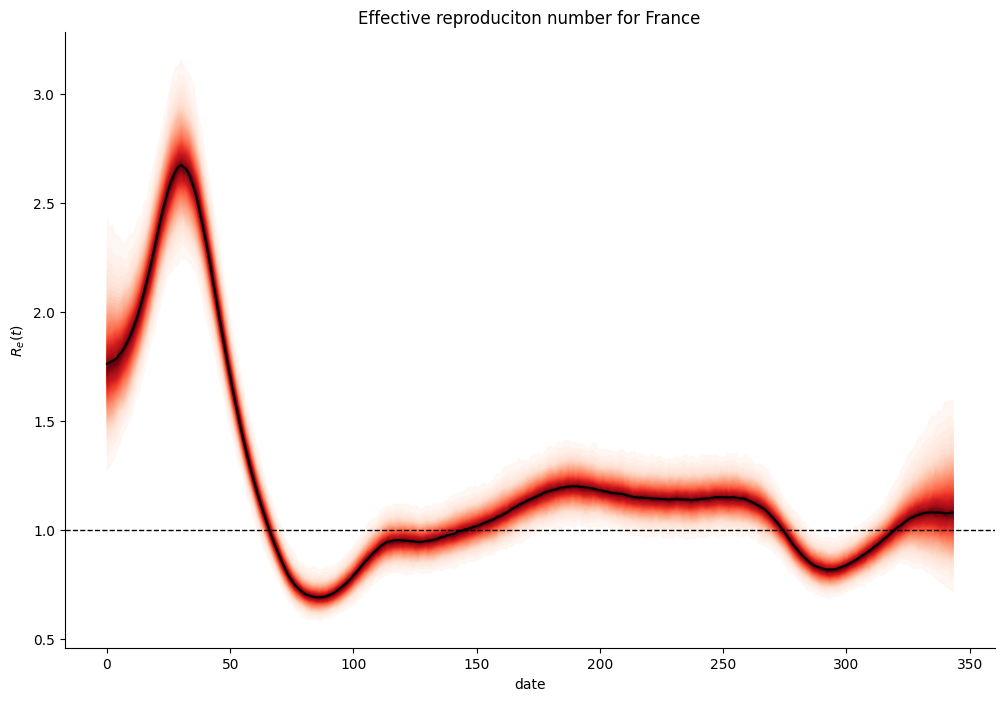

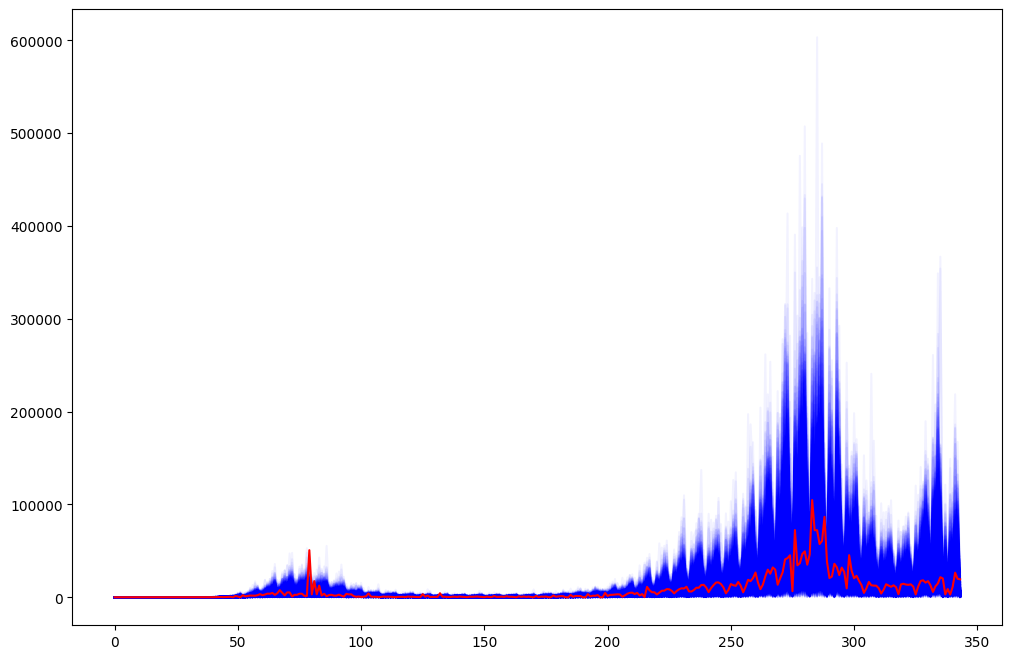

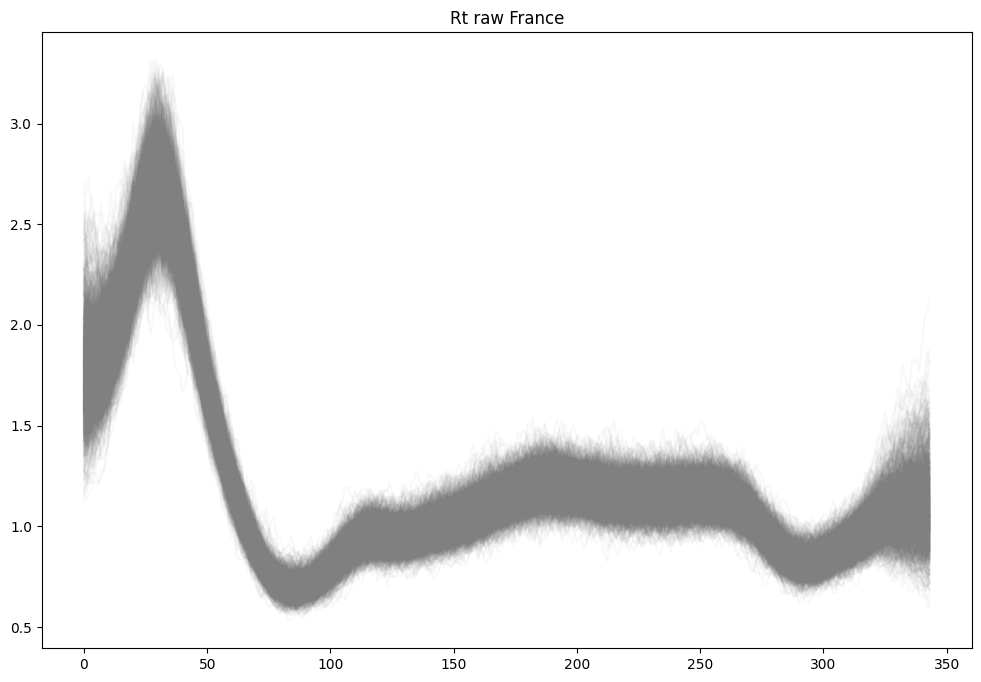

Completed France

Processing Germany...
Using proxy for tests in Germany (NaN ratio: 100.00%)
Sampling prior predictive...
Running main sampling...


c:\Users\User\anaconda3\envs\MRI_NiR\Lib\site-packages\pymc\distributions\timeseries.py:297: UserWarning: Initial distribution not specified, defaulting to `Normal.dist(0, 100)`.You can specify an init_dist manually to suppress this warning.
  warnings.warn(
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (3 chains in 3 jobs)
NUTS: [log_r_t, seed, omega, alpha]


Output()

Sampling 3 chains for 700 tune and 1_500 draw iterations (2_100 + 4_500 draws total) took 3113 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnostics
c:\Users\User\anaconda3\envs\MRI_NiR\Lib\site-packages\arviz\stats\density_utils.py:488: UserWarning: Your data appears to have a single value or no finite values
  warnings.warn("Your data appears to have a single value or no finite values")
c:\Users\User\anaconda3\envs\MRI_NiR\Lib\site-packages\arviz\stats\density_utils.py:488: UserWarning: Your data appears to have a single value or no finite values
  warnings.warn("Your data appears to have a single value or no finite values")
Sampling: [obs]


Output()

Using proxy for tests in Germany (NaN ratio: 100.00%)


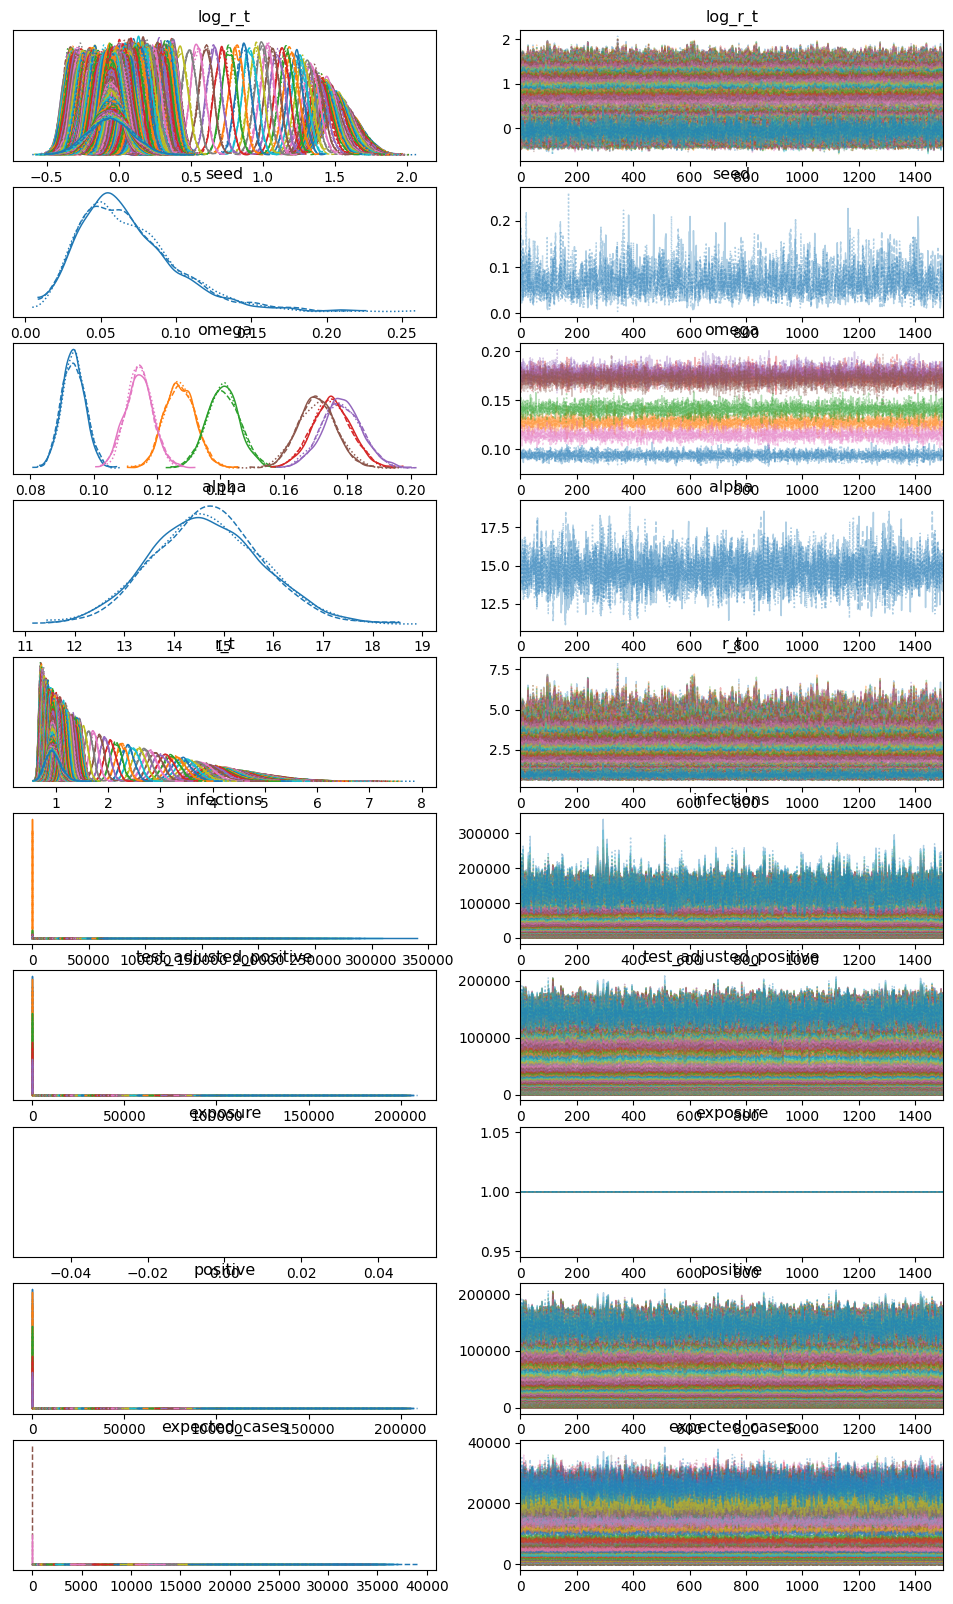

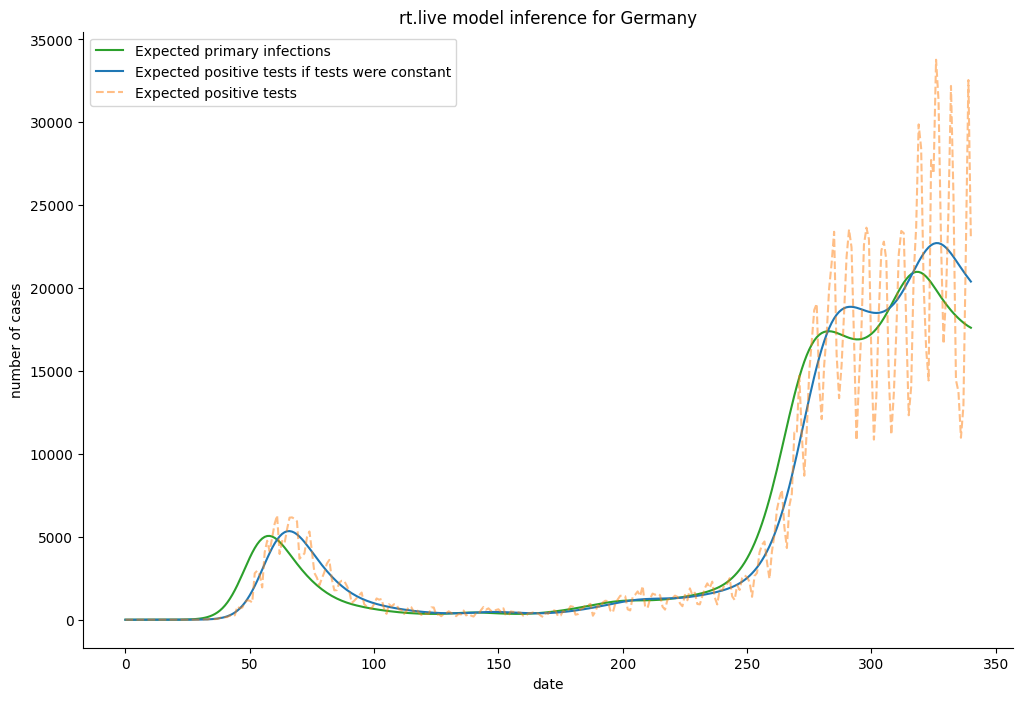

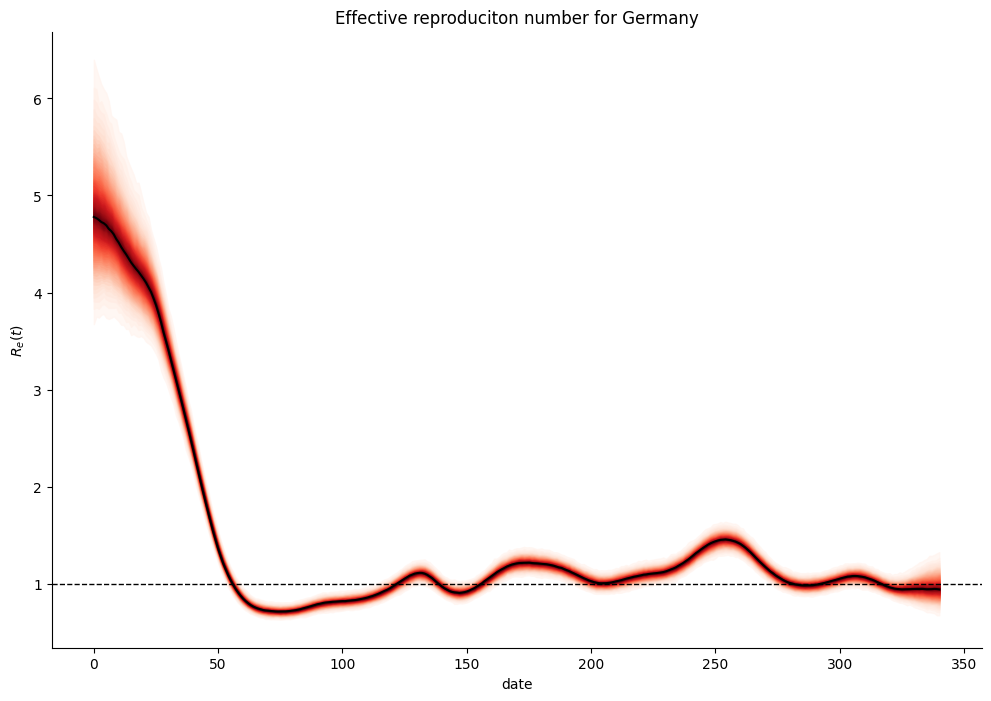

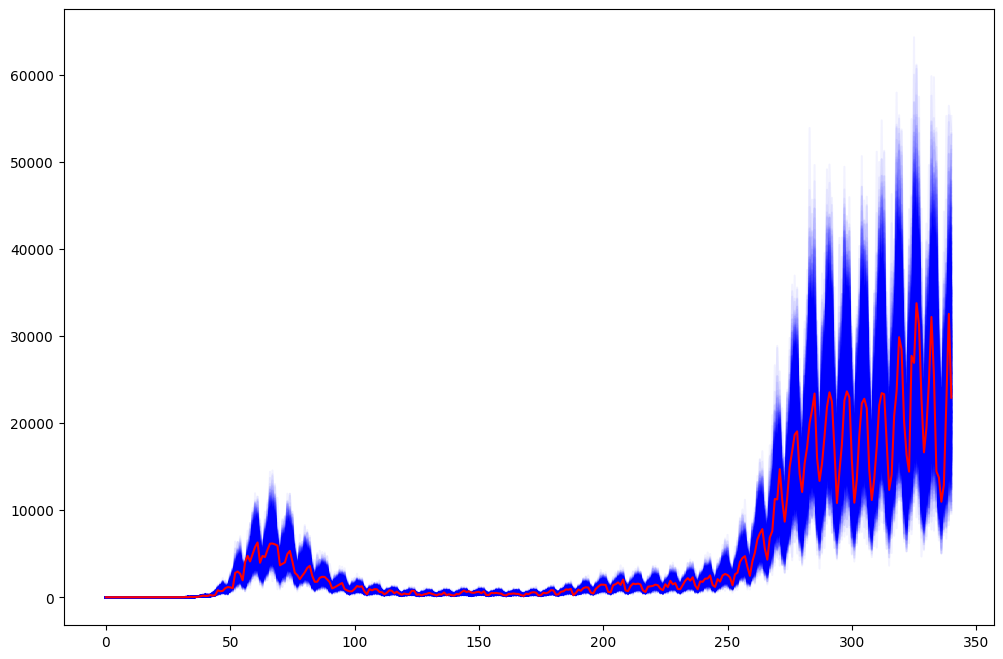

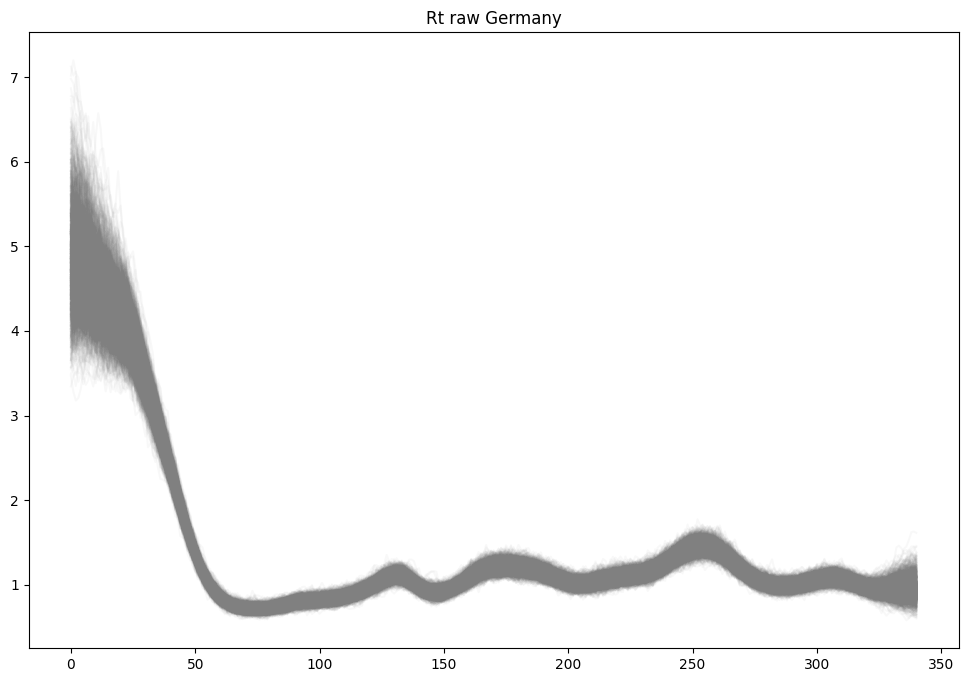

Completed Germany

Processing Russia...
Sampling prior predictive...
Running main sampling...


c:\Users\User\anaconda3\envs\MRI_NiR\Lib\site-packages\pymc\distributions\timeseries.py:297: UserWarning: Initial distribution not specified, defaulting to `Normal.dist(0, 100)`.You can specify an init_dist manually to suppress this warning.
  warnings.warn(
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (3 chains in 3 jobs)
NUTS: [log_r_t, seed, omega, alpha]


Output()

Sampling 3 chains for 700 tune and 1_500 draw iterations (2_100 + 4_500 draws total) took 1951 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnostics
c:\Users\User\anaconda3\envs\MRI_NiR\Lib\site-packages\arviz\stats\density_utils.py:488: UserWarning: Your data appears to have a single value or no finite values
  warnings.warn("Your data appears to have a single value or no finite values")
c:\Users\User\anaconda3\envs\MRI_NiR\Lib\site-packages\arviz\stats\density_utils.py:488: UserWarning: Your data appears to have a single value or no finite values
  warnings.warn("Your data appears to have a single value or no finite values")
Sampling: [obs]


Output()

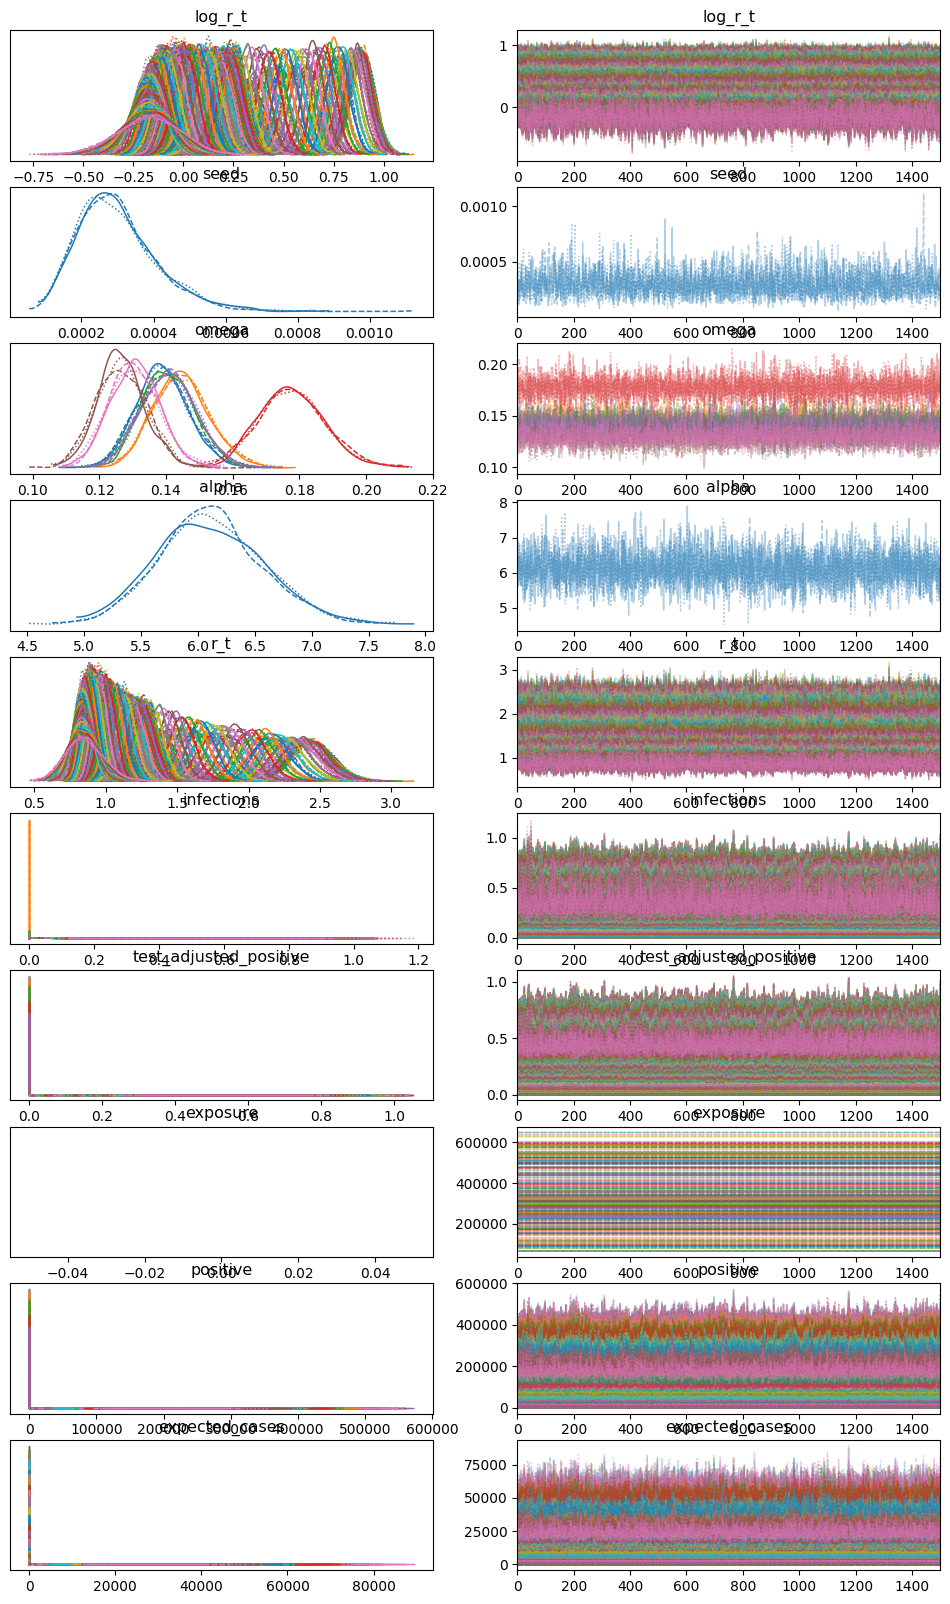

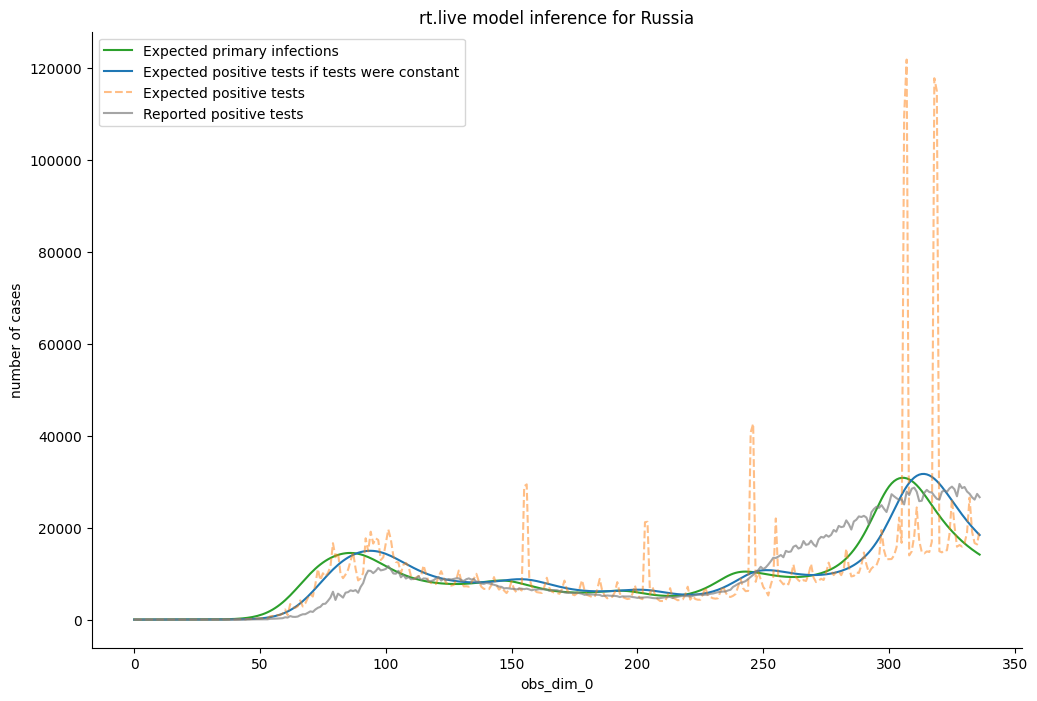

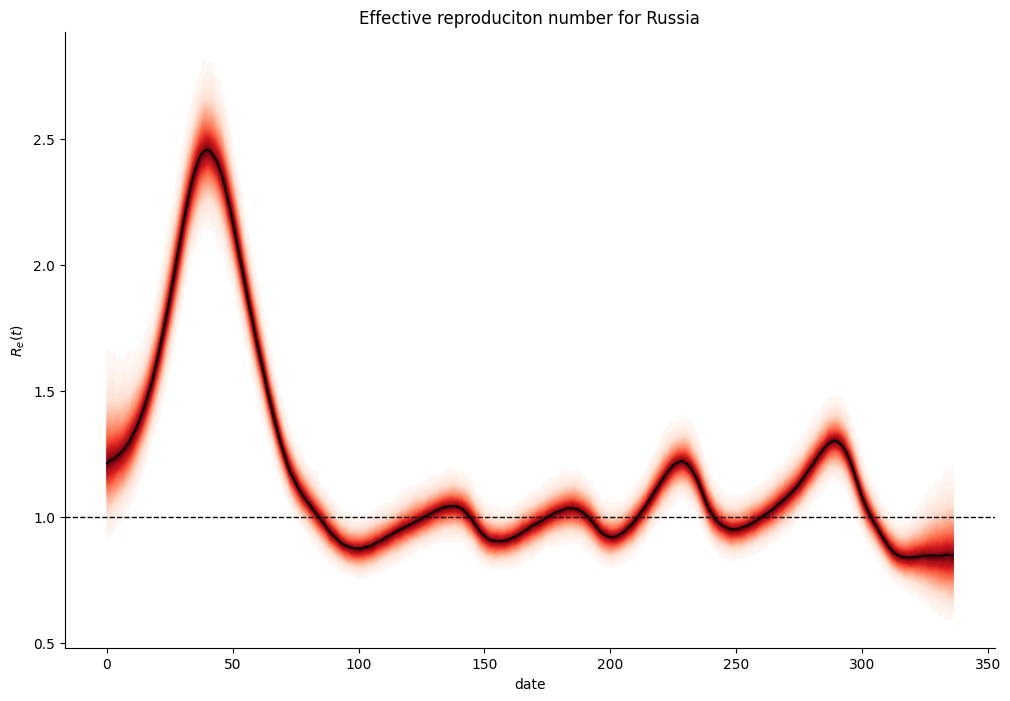

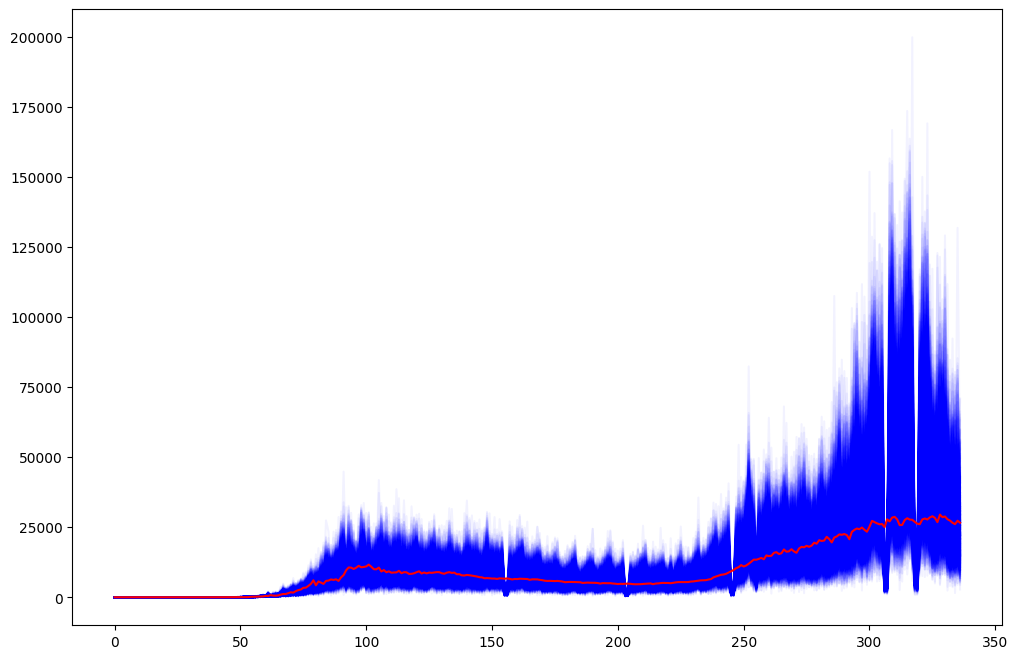

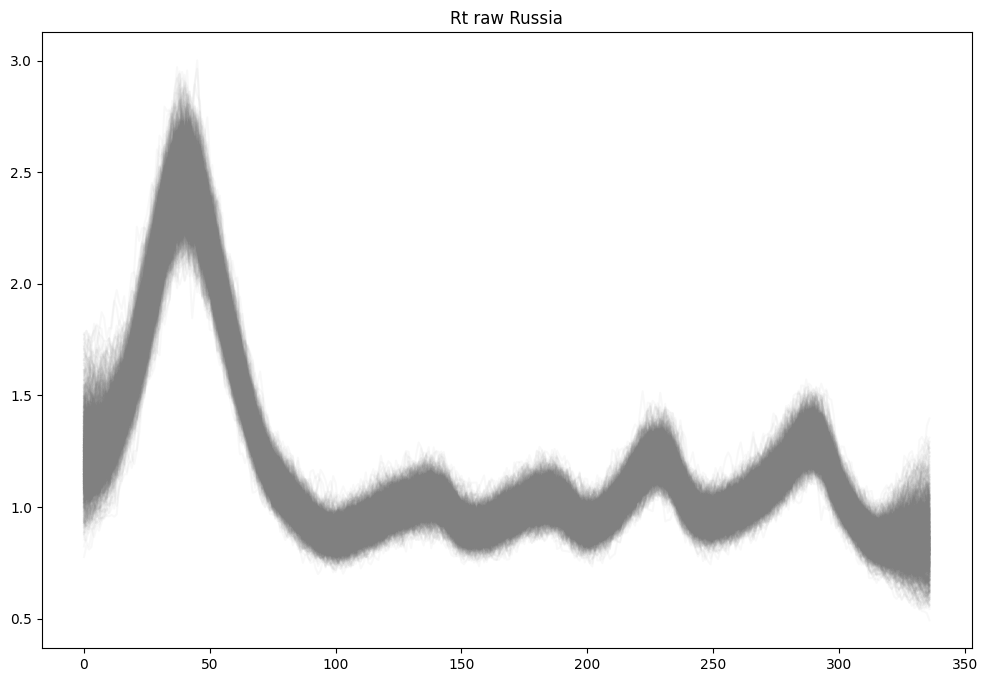

Completed Russia

Processing Italy...
Sampling prior predictive...
Running main sampling...


c:\Users\User\anaconda3\envs\MRI_NiR\Lib\site-packages\pymc\distributions\timeseries.py:297: UserWarning: Initial distribution not specified, defaulting to `Normal.dist(0, 100)`.You can specify an init_dist manually to suppress this warning.
  warnings.warn(
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (3 chains in 3 jobs)
NUTS: [log_r_t, seed, omega, alpha]


Output()

Sampling 3 chains for 700 tune and 1_500 draw iterations (2_100 + 4_500 draws total) took 2160 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnostics
c:\Users\User\anaconda3\envs\MRI_NiR\Lib\site-packages\arviz\stats\density_utils.py:488: UserWarning: Your data appears to have a single value or no finite values
  warnings.warn("Your data appears to have a single value or no finite values")
c:\Users\User\anaconda3\envs\MRI_NiR\Lib\site-packages\arviz\stats\density_utils.py:488: UserWarning: Your data appears to have a single value or no finite values
  warnings.warn("Your data appears to have a single value or no finite values")
Sampling: [obs]


Output()

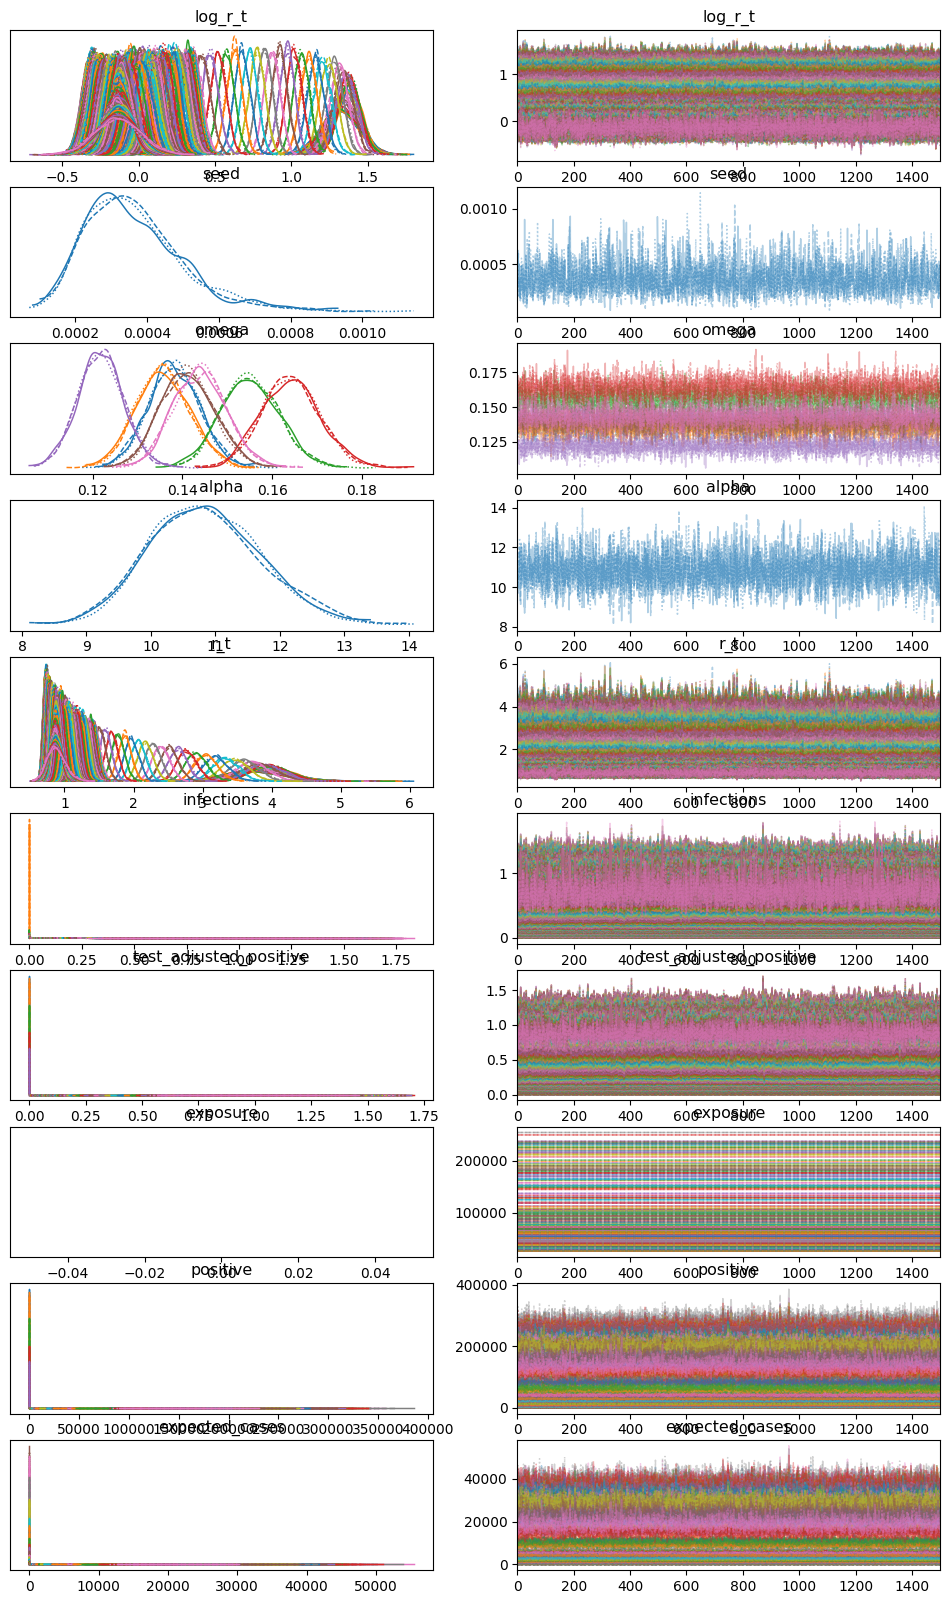

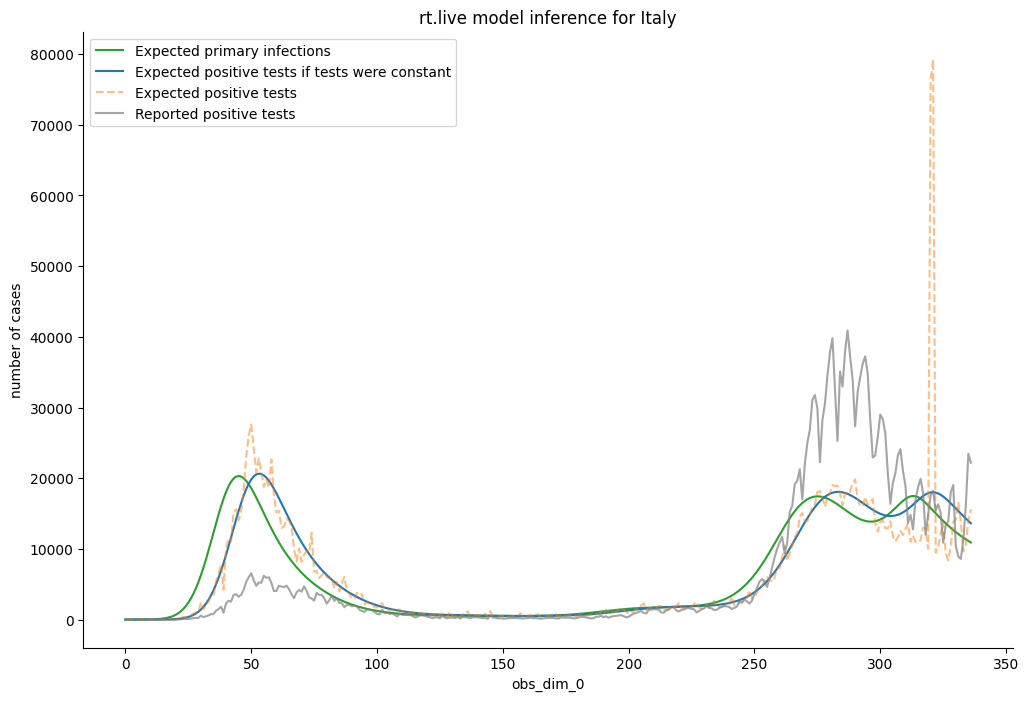

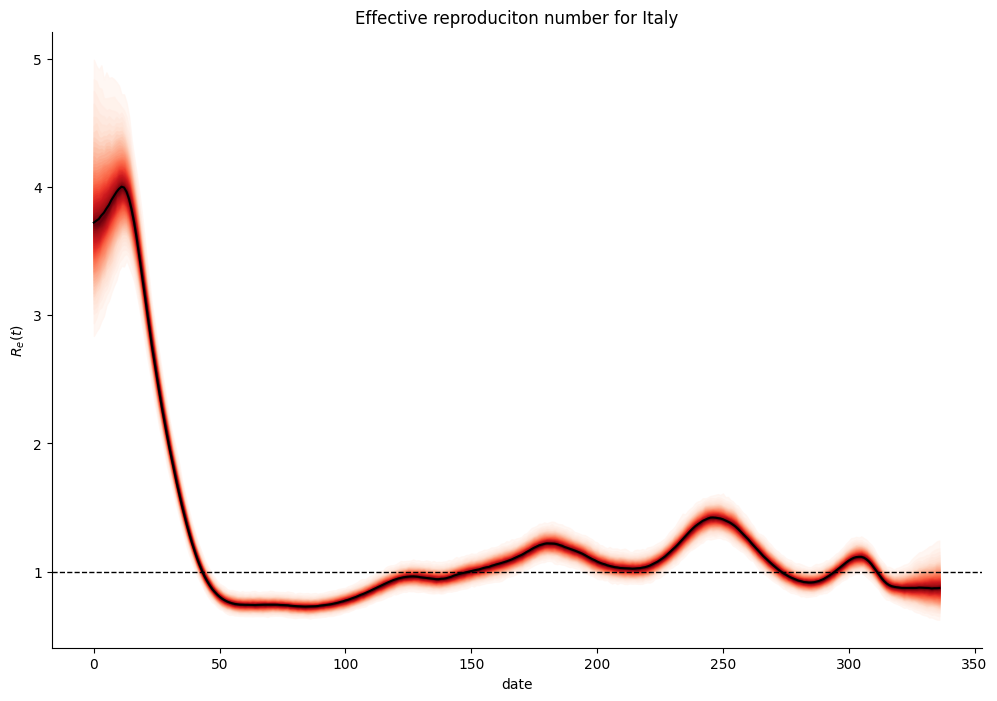

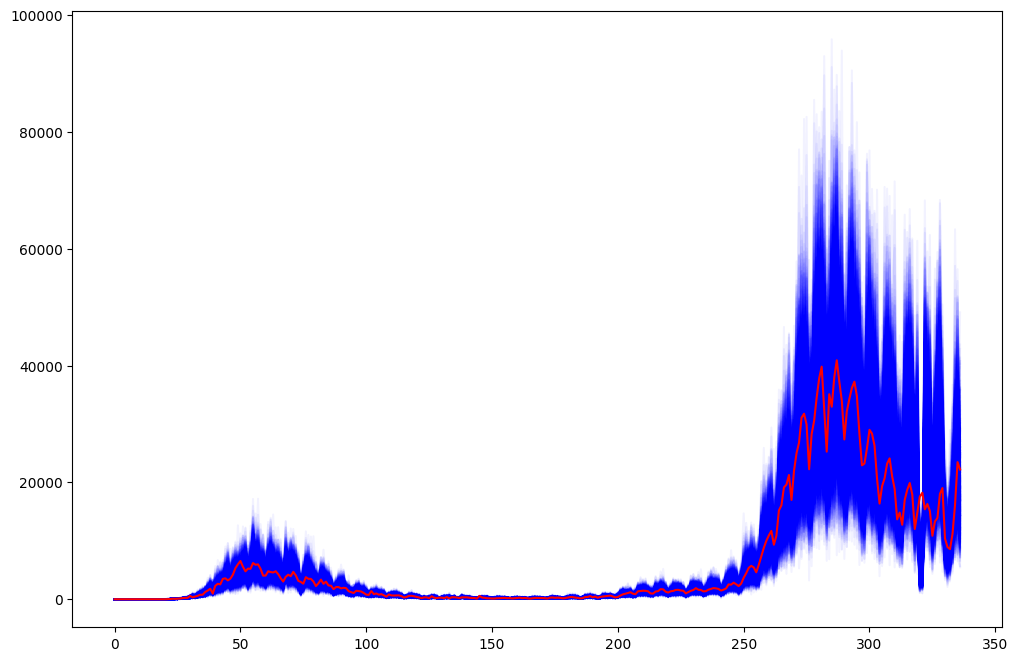

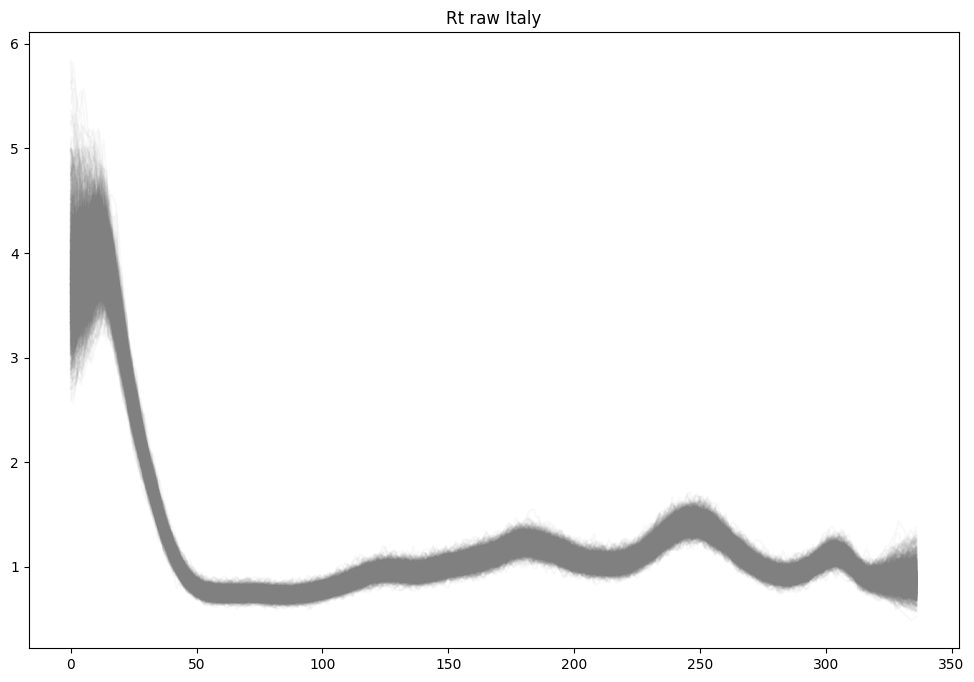

Completed Italy


In [106]:
ountries = [ 'France','Germany','Russia', 'Italy']
results_my_2 = {}
for country in ountries:
    print(f"\nProcessing {country}...")
    # Подготовка данных
    new_cases,total_tests = prepare_data_country(data, country)
    len_observed = len(new_cases)
    convolution_ready_gt = _get_convolution_ready_gt(len_observed)
    
    with pm.Model() as model_rt:
        # Случайное блуждание для log(R_t)
        log_r_t = pm.GaussianRandomWalk(
            "log_r_t",
            sigma=0.035,
            shape=len_observed,
        )
        r_t = pm.Deterministic("r_t", pm.math.exp(log_r_t))

        # Начальное число инфицированных
        seed = pm.Exponential("seed", 1/0.02)
        
        # Инициализация вектора инфекций
        y0 = pt.zeros(len_observed)
        y0 = pt.set_subtensor(y0[0], seed)
        
        # Вычисление инфекций
        outputs, _ = pytensor.scan(
            fn=lambda t, gt, y, r_t: pt.set_subtensor(
                y[t],
                pt.sum(r_t * y * gt)  
            ),
            sequences=[pt.arange(1, len_observed), convolution_ready_gt],
            outputs_info=y0,
            non_sequences=r_t,
            n_steps=len_observed - 1
        )
        
        infections = pm.Deterministic("infections", outputs[-1])

        # Учет задержки регистрации
        test_adjusted_positive = pm.Deterministic(
            "test_adjusted_positive",
            conv_r(infections, p_delay, len_observed)
        )
    
        tests = pm.Data("tests", total_tests.values)
        exposure = pm.Deterministic(
            "exposure",
            pm.math.clip(tests, total_tests.max() * 0.1, 1e9)
        )

        # Test-volume adjust reported cases based on an assumed exposure
        # Note: this is similar to the exposure parameter in a Poisson
        # regression.
        positive = pm.Deterministic(
            "positive", exposure * test_adjusted_positive
        )

        # Еженедельные эффекты
        omega = pm.Dirichlet("omega", a=np.ones(7))
        
        weekly_effect, _ = pytensor.scan(
            fn=lambda t, omega: omega[t % 7],
            sequences=pt.arange( len_observed),
            non_sequences=omega,
            n_steps=len_observed 
        )

        # Ожидаемое число случаев
        expected_cases = pm.Deterministic(
            "expected_cases",
            pt.clip(positive * weekly_effect, 0.1, 1e7)
        )

        # Наблюдения
        alpha = pm.Gamma("alpha", mu=6, sigma=1)
        obs = pm.NegativeBinomial(
            "obs",
            mu=expected_cases,
            alpha=alpha,
            observed=new_cases
        )

  
        print("Sampling prior predictive...")
   
        
        # Основное сэмплирование
    print("Running main sampling...")
    with model_rt:
        trace = pm.sample(
            draws=1500,
            tune=700,
            chains=3,
            cores=12,
            target_accept=0.95,
            progressbar=True,
            return_inferencedata=True
        )

    # Сохраняем результаты для страны
    results_my_2[country] = {
        'model': model_rt,
        'trace': trace,
#             'prior_pred': prior_pred,
        'new_cases': new_cases,
        'len_observed': len_observed
    }

    az.plot_trace(results_my_2[country]['trace'], compact=True);
    result = summarize_inference_data(results_my_2[country]['trace'], new_cases)
    region = country

    fig, ax = plt.subplots(figsize=(12, 8))
    result.infections.plot(c="C2", label="Expected primary infections")
    result.test_adjusted_positive.plot(
        c="C0", label="Expected positive tests if tests were constant"
    )
    result.test_adjusted_positive_raw.plot(
        c="C1", alpha=0.5, label="Expected positive tests", style="--"
    )
    if region != 'Germany':
        results_my_2[region]['trace'].observed_data.obs.plot(c="C7", alpha=0.7, label="Reported positive tests")
    fig.set_facecolor("w")
    ax.legend()
    ax.set(title=f"rt.live model inference for {region}", ylabel="number of cases")
    sns.despine();

    fig, ax = plt.subplots(figsize=(12, 8))
    ax.set(title=f"Effective reproduciton number for {region}", ylabel="$R_e(t)$")
    samples = results_my_2[region]['trace'].posterior["r_t"][-1,:,:]
    x = result.index
    cmap = plt.get_cmap("Reds")
    percs = np.linspace(51, 99, 40)
    colors = (percs - np.min(percs)) / (np.max(percs) - np.min(percs))
    samples = samples.T

    result["median"].plot(c="k", ls="-")

    for i, p in enumerate(percs[::-1]):
        upper = np.percentile(samples, p, axis=1)
        lower = np.percentile(samples, 100 - p, axis=1)
        color_val = colors[i]
        ax.fill_between(x, upper, lower, color=cmap(color_val), alpha=0.8)

    ax.axhline(1.0, c="k", lw=1, linestyle="--")
    sns.despine();

    with results_my_2[country]['model']:
        post_pred_r_t = pm.sample_posterior_predictive(results_my_2[country]['trace'].posterior)
    new_cases,total_tests = prepare_data_country(data, country)
    fig, ax = plt.subplots(figsize=(12, 8))
    ax.plot(post_pred_r_t.posterior_predictive.obs[-1,:,:].T, color="b", alpha=0.05)
    ax.plot(new_cases.values, color="r")

    fig, ax = plt.subplots(figsize=(12, 8))
    ax.plot(results_my_2[country]['trace'].posterior["r_t"][-1,:,:].T, color="0.5", alpha=0.05)
    ax.set(title=f"Rt raw {region}")
    plt.show()
    print(f"Completed {country}")

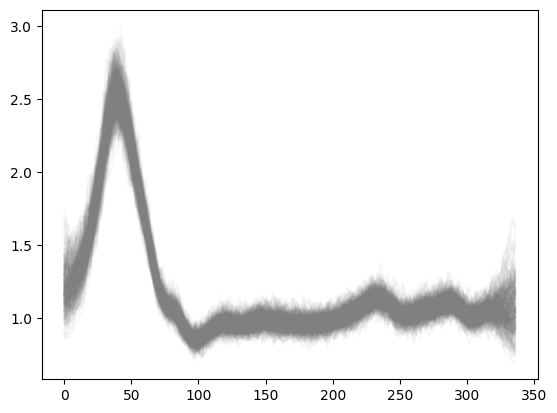

In [101]:
plt.plot(results[country]['trace'].posterior["r_t"][-1,:,:].T, color="0.5", alpha=0.05)
